# housekeeping

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
# ! python --version

Python 3.9.16


In [3]:
# !sudo pip install polars

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# !sudo pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# ! sudo pip install numpyro

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.2/300.2 KB 16.8 MB/s eta 0:00:00


In [1]:
import polars as pl
import numpy as np
import optuna
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import sklearn.metrics
from functools import partial
import pickle
import pandas as pd
from matplotlib import pyplot as plt
import pymc as pm
import arviz as az
import pytensor.tensor as at
import numpyro
import jax
import pymc.sampling_jax as pmjax

In [2]:
# lightgbm で使う num_threads の調査のため
import multiprocessing
multiprocessing.cpu_count()

4

In [3]:
# seed
RANDOM_SEED = 1013

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

zsh:1: command not found: nvidia-smi


In [5]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 8.6 gigabytes of available RAM

Not using a high-RAM runtime


# 読み込み

データフレームに付けるヘッダーを作る

In [6]:
columns = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 
           'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
           'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3']

In [7]:
Soil_Type = ['Soil_Type']*40
int_series = np.arange(0, 40)

soils = pl.DataFrame({
    'Soil_Type': Soil_Type,
    'int_series': list(int_series)
})

soils = soils.with_columns(
    pl.concat_str([
        pl.col('Soil_Type'),
        pl.col('int_series')
        ], 
        separator='_'
    ).alias("Soil_Type's")
)

all_columns = columns \
    + list(np.concatenate(soils.select(pl.col("Soil_Type's")).to_numpy())) \
    + ['Cover_Type']
len(all_columns)

55

作ったヘッダーを、`covtype_copy.data` として新規作成したデータに付け加えるよう編集する

データを読み込む  
目的変数を -1 していることに注意

In [9]:
dtypes = dict(zip(all_columns, [int]*55))

df = pl.read_csv('../data/covtype_copy.data', dtypes=dtypes)
# df = pl.read_csv('./drive/MyDrive/Learning/CA_tech/covtype_copy.data', dtypes=dtypes)
df =\
df.select([
    pl.exclude('Cover_Type'),
    pl.col('Cover_Type')-1
    ])

# train, test 分割

In [23]:
X = df.select(pl.exclude('Cover_Type'))
y = df.select('Cover_Type')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=RANDOM_SEED)
X_train, X_test, y_train, y_test = X_train.to_pandas(), X_test.to_pandas(), y_train.to_pandas(), y_test.to_pandas()

In [24]:
y_train_dummies = pd.get_dummies(np.concatenate(y_train.values))
y_train_dummies

,0,1,2,3,4,5,6
0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...
116197,0,1,0,0,0,0,0
116198,0,1,0,0,0,0,0
116199,0,0,0,0,0,1,0
116200,0,1,0,0,0,0,0


In [25]:
y_test_dummies = pd.get_dummies(np.concatenate(y_test.values))

# 問1. LightGBM

Optuna でハイパーパラメータチューニングする

In [26]:
def objective(trial, X_train, y_train):
    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy()
    train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.25)
    dtrain = lgb.Dataset(train_x, label=train_y)

    param = {
        'objective': 'multiclass',
        'boosting': 'dart',
        'num_iterations': 100, #???
        # 'learning_rate': trial.suggest_int("learning_rate", 0.01, 0.1), #
        'num_leaves': trial.suggest_int("num_leaves", 2, 256), #
        'tree_learner': 'data',
        'num_threads': 4, 
        'seed': 1013,
        'bagging_fraction': trial.suggest_float("bagging_fraction", 0.4, 1.0), #
        'bagging_freq': trial.suggest_int("bagging_freq", 1, 7), #
        'bagging_seed': 1013,
        'feature_fraction': trial.suggest_float("feature_fraction", 0.4, 1.0), #
        'feature_fraction_seed': 1013,
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'drop_rate': 0.1, #???
        'drop_seed': 1013,
        'verbosity': -1,
        'min_data_in_leaf': trial.suggest_int("min_data_in_leaf", 5, 100), #
        'metric': 'multi_logloss',
        'num_class': 7
    }

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(valid_x)
    rounded_labels = np.argmax(preds, axis=1)
    # pred_labels = np.rint(rounded_labels)
    accuracy = sklearn.metrics.accuracy_score(valid_y, rounded_labels)
    return accuracy


# f = partial(objective, X_train=X_train, y_train=y_train)
# study = optuna.create_study(direction="maximize")
# study.optimize(f, n_trials=100)

# print("Number of finished trials: {}".format(len(study.trials)))

# print("Best trial:")
# trial = study.best_trial

# print("  Value: {}".format(trial.value))

# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

チューンしたパラメータを保存する

In [27]:
# pickle.dump(study, open(f"optuna_lgb.pkl", 'wb')) 
optuna_study = pickle.load(open(f'../data/optuna_lgb.pkl', 'rb'))
optuna_study.best_params

{'num_leaves': 256,
 'bagging_fraction': 0.7657196713371847,
 'bagging_freq': 7,
 'feature_fraction': 0.9863362932356322,
 'lambda_l1': 3.418204309170793e-06,
 'lambda_l2': 1.0803561007456372e-06,
 'min_data_in_leaf': 72}

In [28]:
updated_params = {
    'objective': 'multiclass',
    'boosting': 'dart',
    'num_iterations': 100, #???
    # 'learning_rate': trial.suggest_int("learning_rate", 0.01, 0.1), #
    # 'num_leaves': trial.suggest_int("num_leaves", 2, 256), #
    'tree_learner': 'data',
    'num_threads': 4, 
    'seed': 1013,
    # 'bagging_fraction': trial.suggest_float("bagging_fraction", 0.4, 1.0), #
    # 'bagging_freq': trial.suggest_int("bagging_freq", 1, 7), #
    'bagging_seed': 1013,
    # 'feature_fraction': trial.suggest_float("feature_fraction", 0.4, 1.0), #
    'feature_fraction_seed': 1013,
    # 'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
    # 'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
    'drop_rate': 0.1, #???
    'drop_seed': 1013,
    'verbosity': -1,
    # 'min_data_in_leaf': trial.suggest_int("min_data_in_leaf", 5, 100), #
    'metric': 'multi_logloss',
    'num_class': 7
    }
updated_params.update(optuna_study.best_params)
updated_params

{'objective': 'multiclass',
 'boosting': 'dart',
 'num_iterations': 100,
 'tree_learner': 'data',
 'num_threads': 4,
 'seed': 1013,
 'bagging_seed': 1013,
 'feature_fraction_seed': 1013,
 'drop_rate': 0.1,
 'drop_seed': 1013,
 'verbosity': -1,
 'metric': 'multi_logloss',
 'num_class': 7,
 'num_leaves': 256,
 'bagging_fraction': 0.7657196713371847,
 'bagging_freq': 7,
 'feature_fraction': 0.9863362932356322,
 'lambda_l1': 3.418204309170793e-06,
 'lambda_l2': 1.0803561007456372e-06,
 'min_data_in_leaf': 72}

LightGBM で推論する

In [65]:
train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.25, random_state=RANDOM_SEED)

dtrain = lgb.Dataset(train_x, label=train_y)
dvalid = lgb.Dataset(valid_x, label=valid_y, reference=dtrain)

evals = {}

gbm = lgb.train(
    params=updated_params, train_set=dtrain, valid_sets=[dtrain, dvalid], callbacks=[lgb.record_evaluation(evals)]
    )
preds = gbm.predict(X_test)
rounded_labels = np.argmax(preds, axis=1)
accuracy = sklearn.metrics.accuracy_score(y_test, rounded_labels)

accuracy


/Users/domolm/.pyenv/versions/3.10.9/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


0.9074783244766679

学習曲線を描く

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='multi_logloss'>

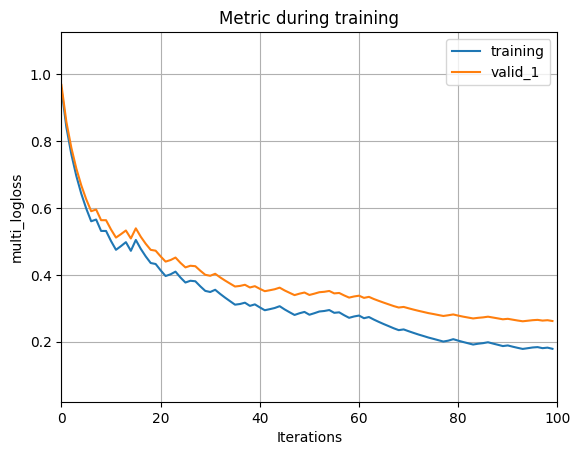

In [66]:
lgb.plot_metric(booster=evals)

特徴量重要度を可視化

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

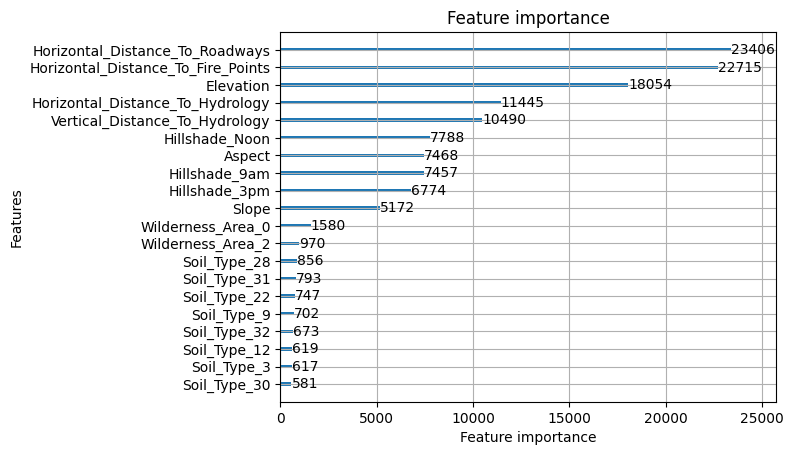

In [32]:
lgb.plot_importance(gbm, max_num_features=20)

permutation feature importance を考察

In [62]:
train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.25, random_state=RANDOM_SEED)

dtrain = lgb.Dataset(train_x, label=train_y)
dvalid = lgb.Dataset(valid_x, label=valid_y, reference=dtrain)

evals = {}

gbm2 = lgb.LGBMClassifier(**updated_params)
gbm2.fit(train_x, train_y)

/Users/domolm/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/domolm/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/domolm/.pyenv/versions/3.10.9/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9863362932356322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9863362932356322
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] lambda_l2 is set=1.0803561007456372e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0803561007456372e-06
[LightGBM] [Warning] bagging_fraction is set=0.7657196713371847, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7657196713371847
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] lambda_l1 is set=3.418204309170793e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4

LGBMClassifier(bagging_fraction=0.7657196713371847, bagging_freq=7,
               bagging_seed=1013, boosting='dart', drop_rate=0.1,
               drop_seed=1013, feature_fraction=0.9863362932356322,
               feature_fraction_seed=1013, lambda_l1=3.418204309170793e-06,
               lambda_l2=1.0803561007456372e-06, metric='multi_logloss',
               min_data_in_leaf=72, num_class=7, num_iterations=100,
               num_leaves=256, num_threads=4, objective='multiclass', seed=1013,
               tree_learner='data', verbosity=-1)

In [63]:
import eli5
from eli5.sklearn import PermutationImportance
r = PermutationImportance(gbm2, random_state=RANDOM_SEED).fit(X_test, y_test)
eli5.show_weights(r, feature_names=X_test.columns.tolist())

Weight,Feature
0.4162 ± 0.0007,Elevation
0.1518 ± 0.0004,Horizontal_Distance_To_Roadways
0.1242 ± 0.0006,Horizontal_Distance_To_Fire_Points
0.0545 ± 0.0006,Horizontal_Distance_To_Hydrology
0.0502 ± 0.0005,Wilderness_Area_0
0.0324 ± 0.0004,Hillshade_Noon
0.0309 ± 0.0003,Vertical_Distance_To_Hydrology
0.0182 ± 0.0002,Hillshade_9am
0.0115 ± 0.0004,Aspect
0.0102 ± 0.0002,Wilderness_Area_2


# 問2

## データ探索

以下コードは明らかに無駄が多い。polars と pandas の互換コードを要勉強

In [39]:
# 元のデータフレームを読み込む
df_c = pd.read_csv('../data/covtype_copy.data')
df_c_pl = pl.read_csv('../data/covtype_copy.data')

# ダミー変数の列を削除し、重複を削除したユニークなカテゴリ値のリストを取得する
cat_values_wil = df_c.iloc[:,10:14].drop_duplicates().values.tolist()  # カテゴリ変数のユニークな値をリスト化
# 新しいカテゴリ変数列を作成する
wil = df_c.iloc[:,10:14].apply(lambda x: cat_values_wil.index(x.values.tolist()), axis=1).values  # カテゴリ変数の値をインデックスに変換

cat_values_soil = df_c.iloc[:,14:-1].drop_duplicates().values.tolist() 
soil = df_c.iloc[:,14:-1].apply(lambda x: cat_values_soil.index(x.values.tolist()), axis=1).values

cover = df_c.iloc[:,-1]

df_new = pl.DataFrame({
    'Wilderness_Areas': wil,
    'Soil_Types': soil,
    'Cover_Type': cover
})

df_old = df_c_pl[:,0:10]
df_cat = pl.concat([df_old, df_new], how='horizontal')
df_cat

Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Areas,Soil_Types,Cover_Type
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
2596,51,3,258,0,510,221,232,148,6279,0,0,5
2590,56,2,212,-6,390,220,235,151,6225,0,0,5
2804,139,9,268,65,3180,234,238,135,6121,0,1,2
2785,155,18,242,118,3090,238,238,122,6211,0,2,2
2595,45,2,153,-1,391,220,234,150,6172,0,0,5
2579,132,6,300,-15,67,230,237,140,6031,0,0,2
2606,45,7,270,5,633,222,225,138,6256,0,0,5
2605,49,4,234,7,573,222,230,144,6228,0,0,5
2617,45,9,240,56,666,223,221,133,6244,0,0,5


In [52]:
df_wil = df_cat.groupby('Wilderness_Areas')\
.agg([
    pl.count(),
    pl.col('Horizontal_Distance_To_Roadways'),
    pl.col('Horizontal_Distance_To_Fire_Points'),
    pl.col('Elevation'),
    pl.col('Horizontal_Distance_To_Hydrology')
])

df_wil = df_wil.sort('Wilderness_Areas')

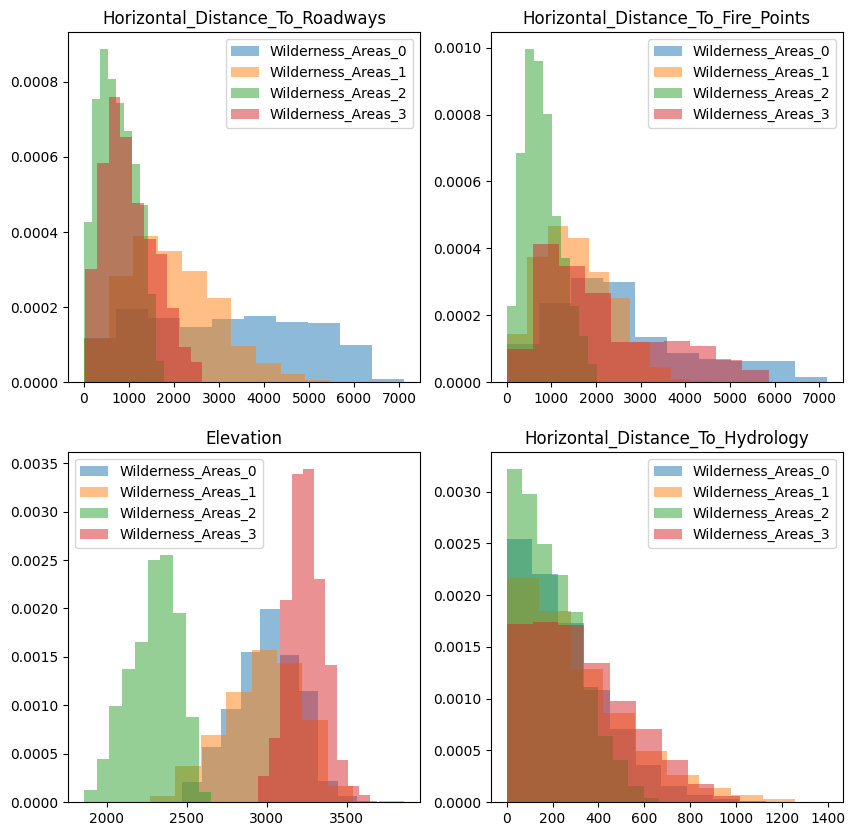

In [53]:
fig, ax = plt.subplots(figsize = (10, 10),
                      ncols=2, nrows=2, sharex=False, sharey=False)
for index, data in df_wil.to_pandas().iterrows():
    ax[0,0].hist(data['Horizontal_Distance_To_Roadways'], density=True, alpha=0.5, label=f'Wilderness_Areas_{index}')
    ax[0,0].legend()
    ax[0,0].set_title('Horizontal_Distance_To_Roadways')

for index, data in df_wil.to_pandas().iterrows():
    ax[0,1].hist(data['Horizontal_Distance_To_Fire_Points'], density=True, alpha=0.5, label=f'Wilderness_Areas_{index}')
    ax[0,1].legend()
    ax[0,1].set_title('Horizontal_Distance_To_Fire_Points')

for index, data in df_wil.to_pandas().iterrows():
    ax[1,0].hist(data['Elevation'], density=True, alpha=0.5, label=f'Wilderness_Areas_{index}')
    ax[1,0].legend()
    ax[1,0].set_title('Elevation')

for index, data in df_wil.to_pandas().iterrows():
    ax[1,1].hist(data['Horizontal_Distance_To_Hydrology'], density=True, alpha=0.5, label=f'Wilderness_Areas_{index}')
    ax[1,1].legend()
    ax[1,1].set_title('Horizontal_Distance_To_Hydrology')

カテゴリ化したデータフレームを保存する

In [56]:
df_cat.write_csv('../data/df_cat.csv')

# multilevel 

In [29]:
# df_cat = pd.read_csv('./data/df_cat.csv')
df_cat = pd.read_csv('./drive/MyDrive/Learning/CA_tech//df_cat.csv')

In [30]:
X = df_cat.drop(['Cover_Type'], axis=1)
y = df_cat['Cover_Type']

In [31]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.99, random_state=1013)

In [32]:
Wilderness_names = X_train.iloc[0:2, -44:-40].columns.values
Wilderness_names

array(['Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2',
       'Wilderness_Area_3'], dtype=object)

In [33]:
fire = X_train['Horizontal_Distance_To_Fire_Points']

In [34]:
preds_name = X_train.drop(['Wilderness_Area_0', 'Wilderness_Area_1', 
                                         'Wilderness_Area_2', 'Wilderness_Area_3'], axis=1).columns.values
COORDS = {'Wil': Wilderness_names}

with pm.Model(coords=COORDS) as multimodel:
    # data
    Wil_ind = pm.MutableData('Wil_ind', X_train2['Wilderness_Areas'].values)
    
    # priors
    sigma_a = pm.HalfCauchy('sigma_a', 5)
    mu_a = pm.Normal('mu_a', mu=0, sigma=10)
    mu_b = pm.Normal("mu_b", mu=0.0, sigma=10.0)
    sigma_b = pm.HalfCauchy("sigma_b", 5)

    # Random intercept
    alpha = pm.Normal('alpha', mu=mu_a, sigma=sigma_a, dims='Wil')
    # Random slopes
    beta = pm.Normal("beta", mu=mu_b, sigma=sigma_b, dims='Wil')

    
    # data likelihood
    logit_y = alpha[Wil_ind] + pm.math.dot(fire, beta[Wil_ind])
    y_obs = pm.Categorical('y_obs', logit_p=logit_y, observed=y_train_dummies)


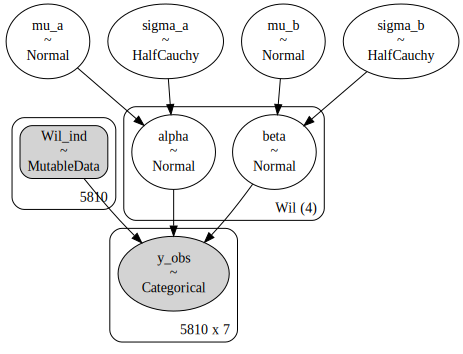

In [35]:
pm.model_to_graphviz(multimodel)

In [36]:
with multimodel:
    multimodel_trace = pmjax.sample_numpyro_nuts(tune=2000, chains=2, random_seed=RANDOM_SEED)

Compiling...


/usr/local/lib/python3.9/dist-packages/pymc/sampling/jax.py:641: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(


Compilation time =  0:00:07.405491
Sampling...


sample: 100%|██████████| 3000/3000 [19:16<00:00,  2.60it/s, 729 steps of size 1.43e-03. acc. prob=0.84]


Sampling time =  0:23:59.723272
Transforming variables...
Transformation time =  0:00:00.015264


array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

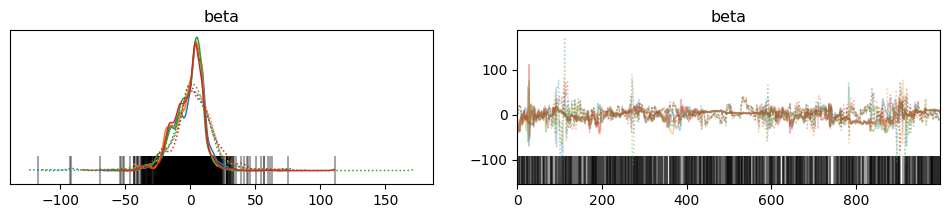

In [41]:
az.plot_trace(multimodel_trace, var_names=['beta'])

In [42]:
az.summary(multimodel_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_a,-1.118,8.964,-17.971,13.780,1.051,0.746,73.0,64.0,1.05
mu_b,0.306,9.721,-19.227,16.637,1.159,0.823,73.0,203.0,1.02
alpha[Wilderness_Area_0],99.755,174.132,-33.748,348.927,26.480,18.852,19.0,83.0,1.10
alpha[Wilderness_Area_1],-18.228,118.591,-209.104,185.504,7.520,9.201,194.0,106.0,1.07
alpha[Wilderness_Area_2],-18.705,107.980,-228.368,168.694,8.424,5.967,169.0,96.0,1.07
alpha[Wilderness_Area_3],-9.854,93.997,-202.891,135.156,8.226,5.829,128.0,111.0,1.07
beta[Wilderness_Area_0],0.427,16.616,-31.732,24.159,1.010,0.976,163.0,310.0,1.01
beta[Wilderness_Area_1],0.378,14.782,-25.557,28.029,1.212,0.859,113.0,219.0,1.02
beta[Wilderness_Area_2],-0.668,15.673,-26.970,24.739,1.169,0.828,112.0,188.0,1.01
beta[Wilderness_Area_3],1.115,14.537,-23.142,30.982,1.106,0.783,131.0,235.0,1.02


In [49]:
with multimodel:
    post = pm.sample_posterior_predictive(multimodel_trace)

In [65]:
post.posterior_predictive['y_obs'].mean(dim=["chain", "draw"])

<xarray.DataArray 'y_obs' (y_obs_dim_2: 5810, y_obs_dim_3: 7)>
array([[2962.552 , 3009.291 , 2915.509 , ..., 2949.1625, 2986.3135,
        2934.2745],
       [2911.3375, 2891.637 , 2970.7115, ..., 2902.709 , 2902.2375,
        2957.0135],
       [2921.169 , 2886.235 , 2947.494 , ..., 2970.9035, 2886.0375,
        2942.6065],
       ...,
       [2901.2355, 2941.981 , 2935.7775, ..., 2923.281 , 2941.5105,
        2910.3175],
       [2888.622 , 2910.996 , 2961.8155, ..., 2948.765 , 2889.3135,
        2922.722 ],
       [2963.4075, 2962.3255, 2943.092 , ..., 2917.514 , 2894.0305,
        2965.554 ]])
Coordinates:
  * y_obs_dim_2  (y_obs_dim_2) int64 0 1 2 3 4 5 ... 5805 5806 5807 5808 5809
  * y_obs_dim_3  (y_obs_dim_3) int64 0 1 2 3 4 5 6

In [71]:
np.mean(np.argmax(post.posterior_predictive['y_obs'].mean(dim=["chain", "draw"]).values, axis=1) == y_train.values)

0.14527036594867299

# 縮小事前分布（正則化）

In [11]:
COORDS = {
    'preds': X_train.columns.values,
    'class': list(np.ones(7)),
    'obs_id': list(np.ones(len(X_train)))
    }
with pm.Model(coords=COORDS) as shrinkage:
    # X = pm.MutableData('X', X_train, dims=('obs_id', 'preds'))
    
    # local shirinkage param
    nu_k = pm.InverseGamma('nu_k', 0.5, 1, dims=('preds','class'))
    lam_k2 = pm.InverseGamma('lam_k2', 0.5, 1/nu_k, dims=('preds','class'))
    
    # global shrinkage param
    xi = pm.InverseGamma('xi', 0.5, 1)
    tau2 = pm.InverseGamma('tau2', 0.5, 1/xi)
    
    # prior
    sigma = pm.HalfCauchy("sigma", 5)
    beta = pm.Normal('beta', 0, pm.math.sqrt(lam_k2)*pm.math.sqrt(tau2)*sigma,
                    dims=('preds','class'))
    
    # likelihood
    mu = pm.math.dot(X_train, beta)
    # link function
    p_y = pm.math.softmax(mu)
    y_like = pm.Bernoulli('y_like', p=p_y, observed = y_train_dummies, dims=('obs_id', 'class'))

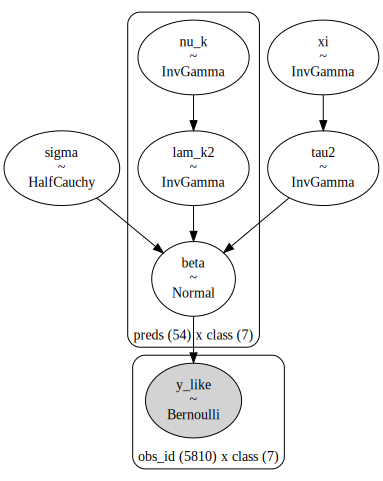

In [12]:
pm.model_to_graphviz(shrinkage)

In [13]:
with shrinkage:
    shrinkage_trace = pmjax.sample_numpyro_nuts(tune=2000, chains=2, random_seed=RANDOM_SEED)

Compiling...


/usr/local/lib/python3.9/dist-packages/pymc/sampling/jax.py:641: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(


Compilation time =  0:00:03.827509
Sampling...


sample: 100%|██████████| 3000/3000 [27:09<00:00,  1.84it/s, 1023 steps of size 2.89e-04. acc. prob=0.92]


Sampling time =  0:57:44.196969
Transforming variables...
Transformation time =  0:00:00.257413


In [21]:
az.rhat(shrinkage_trace)

<xarray.Dataset>
Dimensions:  (preds: 54, class: 7)
Coordinates:
  * preds    (preds) <U34 'Elevation' 'Aspect' ... 'Soil_Type_38' 'Soil_Type_39'
  * class    (class) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0
Data variables:
    beta     (preds, class) float64 1.905 1.852 2.231 ... 2.443 2.085 2.759
    nu_k     (preds, class) float64 2.296 2.425 2.318 ... 2.198 1.962 1.724
    lam_k2   (preds, class) float64 2.254 2.253 2.325 ... 2.055 2.114 2.326
    xi       float64 2.218
    tau2     float64 2.733
    sigma    float64 2.974

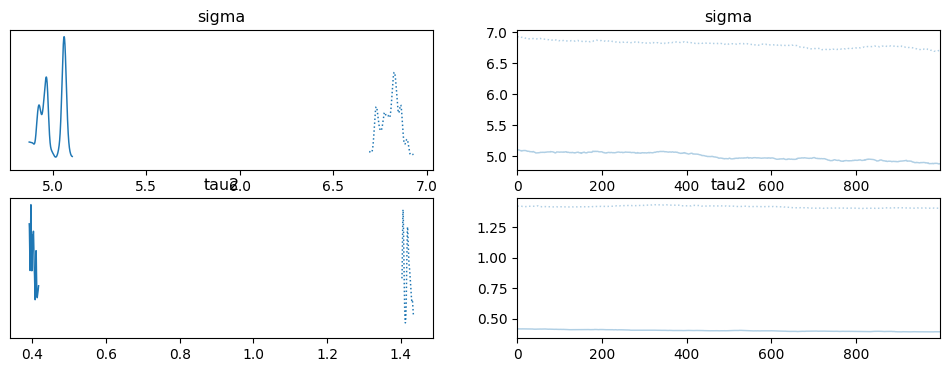

In [20]:
az.plot_trace(shrinkage_trace, var_names=["sigma", "tau2"]);